# TẠO CÁC TẬP DỮ LIỆU TRAIN, TEST (SPLITS)

1. Yêu cầu chung: Tạo ra các splits, mỗi split tương ứng với một tập dữ liệu train - test
  + Bài học lý thuyết (để trả lời cho các câu hỏi như vì sao phải cần việc này, thực hiện việc này như thế nào):
    - https://www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation
    - https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/
    - https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

  <IMG SRC = 'https://raw.githubusercontent.com/satishgunjal/images/master/KFold_Cross_Validation.png'>
  
2. Yêu cầu cụ thể:
- Input:
    + Thư mục cha chứa các thư mục con - mỗi thư mục con tương ứng với tên của từng hiệu xe (Honda, Suzuki, VinFast, Yamaha, Others). Ví dụ: https://drive.google.com/drive/u/1/folders/1Uj0V9URNHpzSHeXHSB89AoGCjGki8Yra
    + Các ảnh được đặt tên theo quy ước: các tập tin ảnh theo quy ước
    + Số splits NumSplits - mặc định NumSplits=5 (tương đương 5-fold CV)
- Output:
    + File CarDataset.csv - Tập tin chứa tất cả ảnh của dataset
      - Chương trình sẽ scan qua cây thư mục để tìm tất cả các ảnh (chỉ chọn các ảnh có định dạng + phần mở rộng là .jpg)
      - Mỗi dòng sẽ có các thông tin cách nhau bằng dấu phẩy, theo quy ước: ImageFullPath, CategoryID
            - ImageFullPath ở dạng <Thư mục Hiệu xe>/<Tên ảnh>. Ví dụ: Honda/2024123.Honda.1.jpg.
            - CategoryID là số nguyên thuộc [0..5] theo quy ước
              - 0: Others
              - 1: Honda
              - 2: Suzuki
              - 3: Yamaha
              - 4: VinFast     
    + File CarDataset-Splits-[1..5]-[Train/Test].csv - Phân chia thành các splits, mỗi split gồm các ảnh được chia thành thành 2 tập Train - Test
      + Chương trình sẽ đọc dữ liệu từ file CarDataset.csv, sau đó với mỗi hiệu xe, chia ngẫu nhiên thành 5 tập dữ liệu. Lưu ý là phải chia theo hiệu xe, để đảm bảo dữ liệu Train/Test có dữ liệu của các hiệu xe.
      + Từ 5 tập dữ liệu chia ngẫu nhiên theo các hiệu xe Xij (i là thứ tự tập dữ liệu, j là CategoryID), gom lại thành 5 tập dữ liệu lớn hơn Xi, sao cho mỗi tập dữ liệu này chứa đủ dữ liệu của tất cả các hiệu xe. Tức là Xi = Union(Xij)       
      + Từ 5 tập dữ liệu Xi này (tương ứng với FOLDi ở trong hình vẽ trên), tạo ra 5 splits Split-i
      + Với mỗi bộ dữ liệu Split-i, ghi xuống thành 2 tập tin tương ứng với Train, Test. Ví dụ Split-1 thì ghi thành tập tin  CarDataset-Splits-1-Train.csv và CarDataset-Splits-1-Test.csv. Tập Train gồm 4 bộ, Test gồm bộ còn lại. Ví dụ,
          + Split-1: tập Train sẽ gồm X2, X3, X4, X5, tập Test là X1
          + Split-5: tập Train sẽ gồm X1, X2, X3, X4, tập Test là X5
      + Mỗi dòng sẽ có các thông tin cách nhau bằng dấu phẩy, theo quy ước: ImageFullPath, CategoryID
- Lưu ý:
  - Nên viết thêm các cell
    - Hiển thị danh sách các tên tập tin ảnh trong từng Split-Train/Test,
    - Thống kê các ảnh cho từng CategoryID trong mỗi Split-Train/Test
  - Cần có chú thích
3. Nộp bài: SV share notebook. Các bài nộp sớm sẽ được full điểm. Deadline: TBA
4. Bài làm đạt yêu cầu sẽ được paste vào notebook với ghi nhận đóng góp từ tác giả.

## Thông tin của tác giả, ngày cập nhật
<hr>

**Thành viên nhóm**:
- **Trần Đình Khánh Đăng - 22520195**
- **Tăng Nhất - 22521027**
- **Lê Minh Nhựt - 22521060**

**Ngày cập nhật**: 13/12/2024

## **Import thư viện cần thiết**

In [1]:
import os
import re
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import KFold

### **Import Drive Colab**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Code**
### **Split KFold**

In [3]:
num_splits = 5

base_dir = './drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Public'
dataset_dir = './drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset'

categories = ['Others', 'Honda', 'Hyundai', 'KIA', 'Mazda', 'Mitsubishi', 'Suzuki', 'Toyota', 'VinFast']

def get_indexing(categories):
    indexing = {category: idx for idx, category in enumerate(categories)}
    invert_indexing = {idx: category for category, idx in indexing.items()}
    return indexing, invert_indexing

indexing, invert_indexing = get_indexing(categories)

In [4]:
def get_dataset(base_dir='./',
                dataset_dir='/',
                categories=['Others', 'Honda', 'Hyundai', 'KIA', 'Mazda', 'Mitsubishi', 'Suzuki', 'Toyota', 'VinFast'],
                save_csv=False,
                file_name='CarDataset.csv',
                ) -> pd.DataFrame:
    """
    Tạo DataFrame chứa thông tin đường dẫn hình ảnh và mã danh mục từ tập dữ liệu theo thương hiệu xe.

    Tham số:
        base_dir (str): Đường dẫn thư mục chứa dữ liệu hình ảnh, trong đó mỗi thư mục con tương ứng với một thương hiệu xe.
        dataset_dir (str): Đường dẫn thư mục để lưu file CSV nếu `save_csv=True`.
        categories (list): Danh sách các thương hiệu xe cần xử lý.
        save_csv (bool): Nếu True, lưu DataFrame ra file CSV.
        file_name (str): Tên file CSV sẽ được lưu nếu `save_csv=True`.

    Returns:
        pd.DataFrame: DataFrame chứa đường dẫn đầy đủ của hình ảnh (ImageFullPath) và mã hiệu xe (CategoryID).
    """
    os.makedirs(dataset_dir, exist_ok=True)  # Tạo thư mục đầu ra nếu chưa tồn tại

    path_list = []  # Lưu đường dẫn đầy đủ của hình ảnh
    categoryid_list = []  # Lưu mã danh mục tương ứng với từng hình ảnh


    student_ids_pattern = r'(\d{8}(?:-\d{8})*)' # Lấy MSSV hợp lệ (đủ 8 số)
    categories_pattern = '|'.join(categories) # Lấy hiệu xe hợp lệ
    file_extension_pattern = r'\.\d+\.(jpg|jpeg|png)$' # Lấy extension hợp lệ (chỉ chấp nhận file .jpg, .jpeg và .png)
    # Regex lấy tên file hợp lệ
    accepted_filename = re.compile(fr'{student_ids_pattern}\.({categories_pattern}){file_extension_pattern}')

    for category in categories: # Duyệt qua các hiệu xe
        category_path = os.path.join(base_dir, category)
        if os.path.isdir(category_path): # Kiểm tra nếu thư mục tồn tại
            for filename in os.listdir(category_path):
                match = accepted_filename.match(filename)
                if match: # Chỉ xử lý file có tên hợp lệ
                    _, car_category, _ = match.groups()
                    if car_category in categories:
                        full_path = os.path.join(car_category, filename)
                        path_list.append(full_path)
                        categoryid_list.append(indexing[car_category])
    # Tạo DataFrame từ danh sách đường dẫn và mã hiệu xe
    df = pd.DataFrame({
        'ImageFullPath': path_list,
        'CategoryID': categoryid_list
    })

    # Lưu CSV nếu cần
    if save_csv:
        output_file = os.path.join(dataset_dir, file_name)
        df.to_csv(output_file, index=False)
        print(f"{file_name} saved to {output_file}")

    return df

In [5]:
def save_kfold_datasets(data=None,
                        num_splits=5,
                        dataset_dir='./',
                        save_csv=False,
                        file_name='CarDataset.csv',
                        random_state=42,
                        ):
    """
    Chia tập dữ liệu thành các tập con để sử dụng cho k-fold cross-validation và lưu ra file CSV.

    Args:
        data (pd.DataFrame hoặc None): Tập dữ liệu cần chia. Nếu là None, tập dữ liệu sẽ được tải từ file CSV được chỉ định bởi `file_name`.
        num_splits (int): Số tập con cần chia (k trong k-fold cross-validation).
        dataset_dir (str): Đường dẫn đến thư mục lưu các tập train/test.
        save_csv (bool): Nếu True, lưu các tập train/test dưới dạng file CSV.
        file_name (str): Tên file CSV chứa dữ liệu gốc cần chia.
        random_state (int): Giá trị seed để xáo trộn dữ liệu khi chia.

    Returns:
        tuple: (train_splits, test_splits)
            - `train_splits`: Danh sách các DataFrame chứa tập train của từng fold.
            - `test_splits`: Danh sách các DataFrame chứa tập test của từng fold.
    """

    os.makedirs(dataset_dir, exist_ok=True)  # Tạo thư mục đầu ra nếu chưa tồn tại

    if data == None:
      # Đọc dữ liệu từ file CSV ban đầu
      data_path = os.path.join(dataset_dir, file_name)
      data = pd.read_csv(data_path)

    path_list = data['ImageFullPath'].values # Danh sách đường dẫn hình ảnh
    categoryid_list = data['CategoryID'].values # Danh sách mã hiệu xe tương ứng

    train_splits = []  # Danh sách chứa các DataFrame tập train
    test_splits = []  # Danh sách chứa các DataFrame tập test

    # Khởi tạo đối tượng KFold
    kfold = KFold(n_splits=num_splits, shuffle=True, random_state=random_state)

    for i, (train_index, test_index) in enumerate(kfold.split(path_list)):
        # Đường dẫn file train/test cho từng tập con
        train_file_path = os.path.join(dataset_dir, f'CarDataset-Splits-{i + 1}-Train.csv')
        test_file_path = os.path.join(dataset_dir, f'CarDataset-Splits-{i + 1}-Test.csv')

        # Tạo DataFrame cho tập train và test
        train_data = pd.DataFrame({
            'ImageFullPath': [path_list[idx] for idx in train_index],
            'CategoryID': [categoryid_list[idx] for idx in train_index]
        })
        test_data = pd.DataFrame({
            'ImageFullPath': [path_list[idx] for idx in test_index],
            'CategoryID': [categoryid_list[idx] for idx in test_index]
        })

        if save_csv:
            # Lưu DataFrame ra file CSV
            train_data.to_csv(train_file_path, index=False)
            test_data.to_csv(test_file_path, index=False)

            print(f"Train fold {i + 1} saved to {train_file_path}")
            print(f"Test fold {i + 1} saved to {test_file_path}")

        train_splits.append(train_data)
        test_splits.append(test_data)

    return train_splits, test_splits

In [6]:
df = get_dataset(base_dir=base_dir, dataset_dir=dataset_dir, categories=categories, save_csv=True)
train_splits, test_splits = save_kfold_datasets(num_splits=num_splits, dataset_dir=dataset_dir, save_csv=True, random_state=42)

CarDataset.csv saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset/CarDataset.csv
Train fold 1 saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset/CarDataset-Splits-1-Train.csv
Test fold 1 saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset/CarDataset-Splits-1-Test.csv
Train fold 2 saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset/CarDataset-Splits-2-Train.csv
Test fold 2 saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset/CarDataset-Splits-2-Test.csv
Train fold 3 saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.P11 - HK1 (2024-2025)/Final Project/Dataset/CarDataset-Splits-3-Train.csv
Test fold 3 saved to ./drive/MyDrive/Classroom/CS114.ML - MACHINE LEARNING CS114.

In [7]:
df

,ImageFullPath,CategoryID
0,Others/22521070-22520211.Others.263.jpg,0
1,Others/22521070-22520211.Others.268.jpg,0
2,Others/22521070-22520211.Others.267.jpg,0
3,Others/22521070-22520211.Others.272.jpg,0
4,Others/22521070-22520211.Others.271.jpg,0
...,...,...
33779,VinFast/22521027-22520195-22521060.VinFast.003...,8
33780,VinFast/22521027-22520195-22521060.VinFast.002...,8
33781,VinFast/22521027-22520195-22521060.VinFast.002...,8
33782,VinFast/22521027-22520195-22521060.VinFast.000...,8


In [8]:
train_splits[0]

,ImageFullPath,CategoryID
0,Others/22521070-22520211.Others.268.jpg,0
1,Others/22521070-22520211.Others.267.jpg,0
2,Others/22521070-22520211.Others.272.jpg,0
3,Others/22521070-22520211.Others.270.jpg,0
4,Others/22521070-22520211.Others.275.jpg,0
...,...,...
27022,VinFast/22521027-22520195-22521060.VinFast.041...,8
27023,VinFast/22521027-22520195-22521060.VinFast.003...,8
27024,VinFast/22521027-22520195-22521060.VinFast.002...,8
27025,VinFast/22521027-22520195-22521060.VinFast.002...,8


In [9]:
def display_splits(train_splits, test_splits, max_files=5) -> None:
    """
    Hiển thị danh sách các file trong các tập train và test cho từng fold của k-fold.

    Args:
        train_splits (list): Danh sách các DataFrame chứa tập dữ liệu train của từng fold.
        test_splits (list): Danh sách các DataFrame chứa tập dữ liệu test của từng fold.
        max_files (int): Số lượng file hình ảnh tối đa sẽ được hiển thị cho mỗi tập (train/test).
    Returns:
        None
    """
    for i, (train_data, test_data) in enumerate(zip(train_splits, test_splits)):
        print(f"\n=================== Split {i + 1} ===================")

        print("Train Files:")
        train_files = train_data['ImageFullPath'].tolist()
        for file in train_files[:max_files]:
            print(file)
        if len(train_files) > max_files:
            print(f"... and {len(train_files) - max_files} more")

        print("\nTest Files:")
        test_files = test_data['ImageFullPath'].tolist()
        for file in test_files[:max_files]:
            print(file)
        if len(test_files) > max_files:
            print(f"... and {len(test_files) - max_files} more")


In [10]:
display_splits(train_splits, test_splits)


=================== Split 1 ===================
Train Files:
Others/22521070-22520211.Others.268.jpg
Others/22521070-22520211.Others.267.jpg
Others/22521070-22520211.Others.272.jpg
Others/22521070-22520211.Others.270.jpg
Others/22521070-22520211.Others.275.jpg
... and 27022 more

Test Files:
Others/22521070-22520211.Others.263.jpg
Others/22521070-22520211.Others.271.jpg
Others/22521070-22520211.Others.269.jpg
Others/22521070-22520211.Others.273.jpg
Others/22521070-22520211.Others.276.jpg
... and 6752 more

=================== Split 2 ===================
Train Files:
Others/22521070-22520211.Others.263.jpg
Others/22521070-22520211.Others.268.jpg
Others/22521070-22520211.Others.267.jpg
Others/22521070-22520211.Others.271.jpg
Others/22521070-22520211.Others.270.jpg
... and 27022 more

Test Files:
Others/22521070-22520211.Others.272.jpg
Others/22521070-22520211.Others.298.jpg
Others/22521070-22520211.Others.299.jpg
Others/22521070-22520211.Others.304.jpg
Others/22521070-22520211.Others.31

## Visualization

In [11]:
def plot_class_distributions(splits, mode='train') -> None:
    """
    Vẽ biểu đồ phân phối các lớp (class) trong các tập dữ liệu chia (train/test) theo từng fold của k-fold.

    Args:
        splits (list): Danh sách chứa các DataFrame tương ứng với các tập dữ liệu train hoặc test cho từng fold.
        mode (str): Chế độ để vẽ phân phối của tập 'train' hoặc 'test'. Mặc định là 'train'.
    Returns:
        None
    """
    num_splits = len(splits)

    fig, axes = plt.subplots(1, num_splits, figsize=(5 * num_splits, 5), sharey=True)
    title = f"Class Distributions Across {'Training' if mode == 'train' else 'Testing'} Splits"
    fig.suptitle(title)

    for i, ax in enumerate(axes):
        class_counts = splits[i]['CategoryID'].value_counts().sort_index()
        class_counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Car-Splits-{i + 1}-Train' if mode == 'train' else f'Car-Splits-{i + 1}-Test')
        ax.set_xlabel('CategoryID')
        if i == 0:
            ax.set_ylabel('Số lượng ảnh')

    plt.tight_layout()
    plt.show()

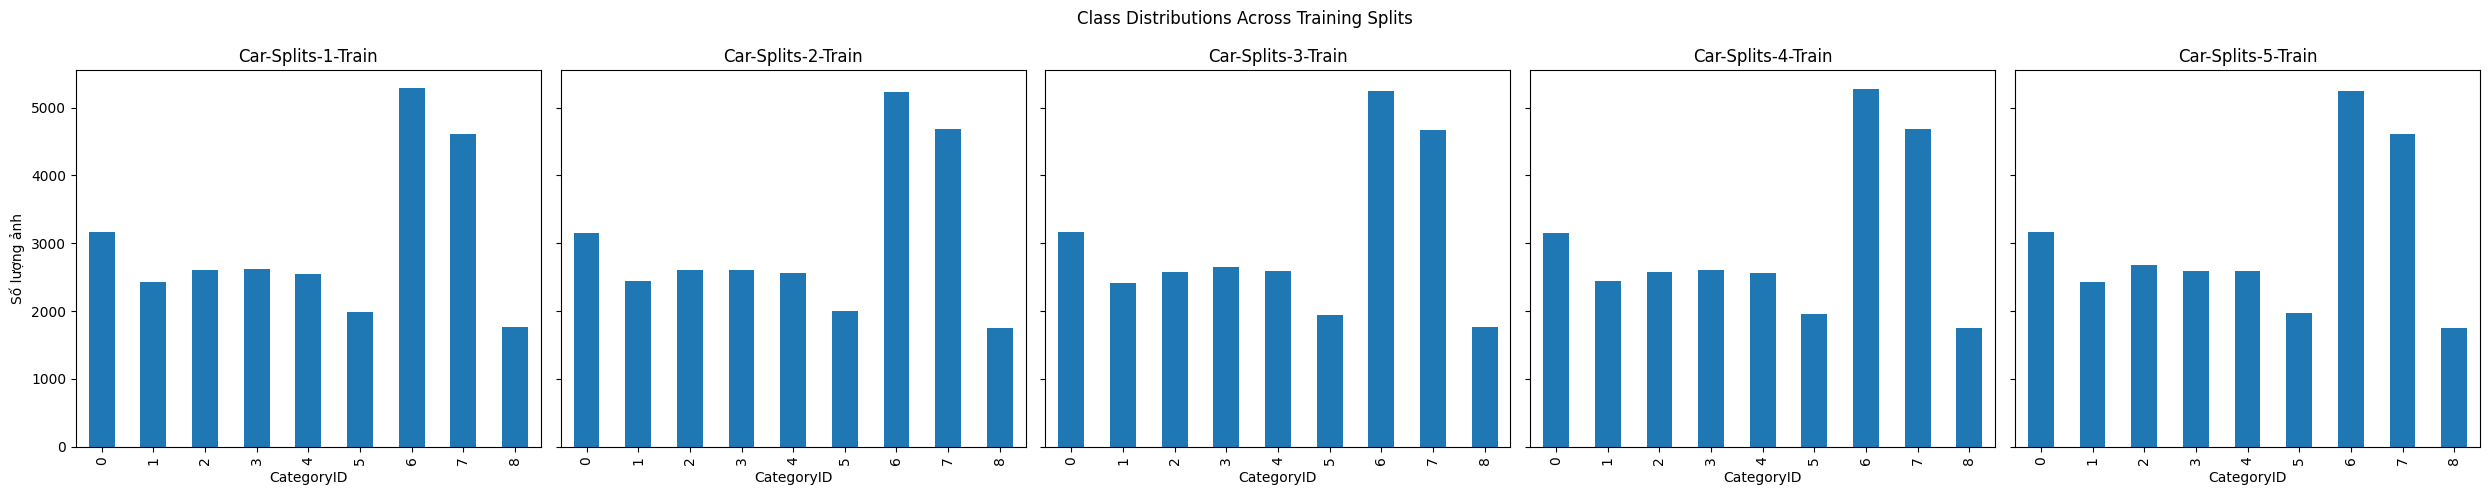

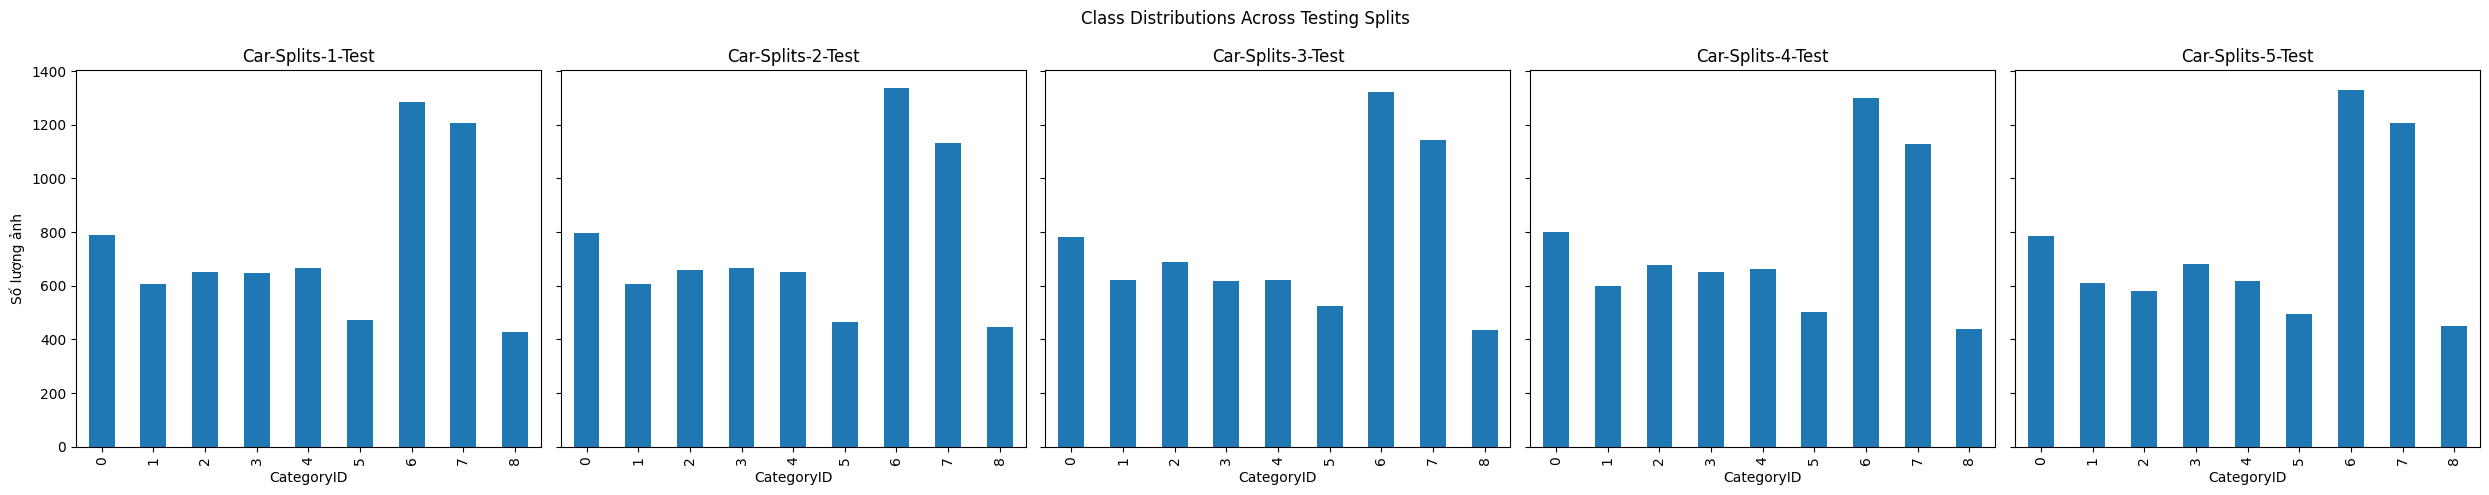

In [12]:
plot_class_distributions(train_splits, mode='train')
plot_class_distributions(test_splits, mode='test')